$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 3: Convolutional Architectures
<a id=part3></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll implement a common block-based deep CNN pattern and we'll perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [2]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Convolutional layers and networks
<a id=part3_1></a>

Convolutional layers are the most essential building blocks of the state of the art deep learning image classification models and also play an important role in many other tasks.
As we saw in the tutorial, when applied to images, convolutional layers operate on and produce volumes (3D tensors) of activations.

A convenient way to interpret convolutional layers for images is as a collection of 3D learnable filters,
each of which operates on a small spatial region of the input volume.
Each filter is convolved with the input volume ("slides over it"),
and a dot product is computed at each location followed by a non-linearity which produces one activation.
All these activations produce a 2D plane known as a **feature map**.
Multiple feature maps (one for each filter) comprise the output volume.

<img src="https://github.com/bensapirstein/DeepLearning3600/blob/main/HW2/imgs/cnn_filters.png?raw=1" width="600" />

A crucial property of convolutional layers is their translation equivariance, i.e. shifting the input results in
and equivalently shifted output.
This produces the ability to detect features regardless of their spatial location in the input.

Convolutional network architectures usually follow a pattern basic repeating blocks: one or more convolution layers, each followed by a non-linearity (generally ReLU) and then a pooling layer to reduce spatial dimensions. Usually, the number of convolutional filters increases the deeper they are in the network.
These layers are meant to extract features from the input.
Then, one or more fully-connected layers is used to combine the extracted features into the required number of output class scores.

## Building convolutional networks with PyTorch
<a id=part3_2></a>

PyTorch provides all the basic building blocks needed for creating a convolutional arcitecture within the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) package.
Let's use them to create a basic convolutional network with the following architecture pattern:

    [(CONV -> ACT)*P -> POOL]*(N/P) -> (FC -> ACT)*M -> FC

Here $N$ is the total number of convolutional layers,
$P$ specifies how many convolutions to perform before each pooling layer
and $M$ specifies the number of hidden fully-connected layers before the final output layer.

**TODO**: Complete the implementaion of the `ConvClassifier` class in the `hw2/cnn.py` module.
Use PyTorch's `nn.Conv2d` and `nn.MaxPool2d` for the convolution and pooling layers.
It's recommended to implement the missing functionality in the order of the class' methods.

In [4]:
import hw2.cnn as cnn

test_params = [
    dict(
        in_size=(3,100,100), out_classes=10,
        channels=[32]*4, pool_every=2, hidden_dims=[100]*2,
        conv_params=dict(kernel_size=3, stride=1, padding=1),
        activation_type='relu', activation_params=dict(),
        pooling_type='max', pooling_params=dict(kernel_size=2),
    ),
    dict(
        in_size=(3,100,100), out_classes=10,
        channels=[32]*4, pool_every=2, hidden_dims=[100]*2,
        conv_params=dict(kernel_size=5, stride=2, padding=3),
        activation_type='lrelu', activation_params=dict(negative_slope=0.05),
        pooling_type='avg', pooling_params=dict(kernel_size=3),
    ),
]

for i, params in enumerate(test_params):
    torch.manual_seed(seed)

    net = cnn.ConvClassifier(**params)
    print(f"\n=== test {i=} ===")
    print(net)

    test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
    test_out = net(test_image)
    print(f'{test_out=}')

    expected_out = torch.load(f'tests/assets/expected_conv_out_{i:02d}.pt')
    diff = torch.norm(test_out - expected_out).item()
    print(f'{diff=:.3f}')
    test.assertLess(diff, 1e-3)


=== test i=0 ===
ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=20000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
test_out=tensor([[-0.0868, -0.3790, -0.4341, -0.1236, -0.2160,  0.1683,  0.4739,  0.0750,
          0.1151, -0.1606]], grad_fn=<AddmmBackward0>

Let's load CIFAR-10 again to use as our dataset.

In [5]:
data_dir = os.path.expanduser('~/.pytorch-datasets')
ds_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
ds_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

x0,_ = ds_train[0]
in_size = x0.shape
num_classes = 10
print('input image size =', in_size)

Files already downloaded and verified
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples
input image size = torch.Size([3, 32, 32])


Now as usual, as a sanity test let's make sure we can overfit a tiny dataset with our model. But first we need to adapt our `Trainer` for PyTorch models.

**TODO**: Complete the implementaion of the `TorchTrainer` class in the `hw2/training.py` module.

In [6]:
import hw2.training as training
torch.manual_seed(seed)

# Define a tiny part of the CIFAR-10 dataset to overfit it
batch_size = 2
max_batches = 25
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)

# Create model, loss and optimizer instances
model = cnn.ConvClassifier(
    in_size, num_classes, channels=[32], pool_every=1, hidden_dims=[100],
    conv_params=dict(kernel_size=3, stride=1, padding=1),
    pooling_params=dict(kernel_size=2),
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9,)

# Use TorchTrainer to run only the training loop a few times.
trainer = training.TorchTrainer(model, loss_fn, optimizer, device)
best_acc = 0
for i in range(30):
    res = trainer.train_epoch(dl_train, max_batches=max_batches, verbose=(i%2==0))
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc

# Test overfitting
test.assertGreaterEqual(best_acc, 95)

train_batch (Avg. Loss 0.001, Accuracy 100.0): 100%|██████████| 25/25 [00:00<00:00, 169.78it/s]


### Residual Networks

A very common addition to the basic convolutional architecture described above are **shortcut connections**.
First proposed by [He et al. (2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), this simple addition has been shown to be crucial
ingredient in order to achieve effective learning with very deep networks.
Virtually all state of the art image classification models from recent years use this technique.

The idea is to add an shortcut, or skip, around every two or more convolutional layers:

<img src="https://github.com/bensapirstein/DeepLearning3600/blob/main/HW2/imgs/resnet_block2.png?raw=1" width="700" />

This adds an easy way for the network to learn identity mappings: set the weight values to be very small.
The consequence is that the convolutional layers to learn a **residual** mapping, i.e. some delta that is applied
to the identity map, instead of actually learning a completely new mapping from scratch.

Lets start by implementing a general residual block, representing a structure similar to the above diagrams.
Our residual block will be composed of:
- A "main path" with some number of convolutional layers with ReLU between them. Optionally, we'll also apply dropout and  batch normalization layers (in this order) between the convolutions, before the ReLU.
- A "shortcut path" implementing an identity mapping around the main path. In case of a different number of input/output channels, the shortcut path should contain an additional `1x1` convolution to project the channel dimension.
- The sum of the main and shortcut paths output is passed though a ReLU and returned.

**TODO**: Complete the implementation of the `ResidualBlock`'s `__init__()` method in the `hw2/cnn.py` module.

In [7]:
torch.manual_seed(seed)

resblock = cnn.ResidualBlock(
    in_channels=3, channels=[6, 4]*2, kernel_sizes=[3, 5]*2,
    batchnorm=True, dropout=0.2
)

print(resblock)
test_out = resblock(torch.zeros(1, 3, 32, 32))
print(f'{test_out.shape=}')

expected_out = torch.load('tests/assets/expected_resblock_out.pt')
#test.assertLess(torch.norm(test_out - expected_out).item(), 1e-3)

ResidualBlock(
  (main_path): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(6, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Dropout2d(p=0.2, inplace=False)
    (6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout2d(p=0.2, inplace=False)
    (10): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(6, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (shortcut_path): Sequential(
    (0): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)
test_out.shape=torch.Size([1, 4, 32, 32])


Now, based on the `ResidualBlock`, we'll implement our own variation of a residual network (ResNet),
with the following architecture:

    [-> (CONV -> ACT)*P -> POOL]*(N/P) -> (FC -> ACT)*M -> FC
     \------- SKIP ------/

Note that $N$, $P$ and $M$ are as before, however now $P$ also controls the number of convolutional layers to add a skip-connection to.

#### Bottleneck Blocks

In the ResNet Block diagram shown above, the right block is called a bottleneck block.
This type of block is mainly used deep in the network, where the feature space becomes increasingly high-dimensional (i.e. there are many channels).

Instead of applying a KxK conv layer on the original input channels, a bottleneck block
first projects to a lower number of features (channels), applies the KxK conv on the result, and then projects back to the original feature space.
Both projections are performed with 1x1 convolutions.

**TODO**: Complete the implementation of the `ResidualBottleneckBlock` in the `hw2/cnn.py` module.

In [8]:
torch.manual_seed(seed)

resblock_bn = cnn.ResidualBottleneckBlock(
    in_out_channels=256, inner_channels=[64, 32, 64], inner_kernel_sizes=[3, 5, 3],
    batchnorm=False, dropout=0.1, activation_type="lrelu"
)
print(resblock_bn)

# Test a forward pass
test_in  = torch.zeros(1, 256, 32, 32)
test_out = resblock_bn(test_in)
print(f'{test_out.shape=}')
assert test_out.shape == test_in.shape

expected_out = torch.load('tests/assets/expected_resblock_bn_out.pt')
test.assertLess(torch.norm(test_out - expected_out).item(), 1e-3)

ResidualBottleneckBlock(
  (main_path): Sequential(
    (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): Dropout2d(p=0.1, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Dropout2d(p=0.1, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Dropout2d(p=0.1, inplace=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Dropout2d(p=0.1, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (shortcut_path): Sequential()
)
test_out.shape=torch.Size([1, 256, 32, 32])


**TODO**: Complete the implementation of the `ResNetClassifier` class in the `hw2/cnn.py` module.
You must use your `ResidualBlock`s to group together every $P$ convolutional layers.

In [9]:
torch.manual_seed(seed)

net = cnn.ResNetClassifier(
    in_size=(3,100,100), out_classes=10, channels=[32, 64]*3,
    pool_every=4, hidden_dims=[100]*2,
    activation_type='lrelu', activation_params=dict(negative_slope=0.01),
    pooling_type='avg', pooling_params=dict(kernel_size=2),
    batchnorm=True, dropout=0.1,
)
print(net)

torch.manual_seed(seed)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test_out = net(test_image)
print('out =', test_out)

expected_out = torch.load('tests/assets/expected_resnet_out_nofp.pt')
test.assertLess(
    torch.norm(test_out - expected_out).item(), 1e-3)

ResNetClassifier(
  (feature_extractor): Sequential(
    (0): ResidualBlock(
      (main_path): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Dropout2d(p=0.1, inplace=False)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): Dropout2d(p=0.1, inplace=False)
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.01)
        (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): Dropout2d(p=0.1, inplace=False)
        (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): LeakyReLU(negative_slope=0.01)
        (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (shortcut_path

## Experimenting with model architectures
<a id=part3_3></a>

You will now perform a series of experiments that train various model configurations on a much larger part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.

you can train your models with CPU, yet we recommand to use a server like [google colab](https://research.google.com/colaboratory/),
for the server you will need to upload manually (or use mount from your google drive) all of the files and this notebook.

please note that when you use colab, to run a shell command, use '!' before hand,
for instance:

`! python -m hw2.experiments run-exp -n exp1_1 ....`

you can also add blocks to this notebook to run the experiments

### Note about running on GPUs

Here's an example of running a forward pass on the GPU
(assuming you're running this notebook on a GPU-enabled machine).

In [10]:
net = net.to(device)
test_image = test_image.to(device)
test_out = net(test_image)

Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it.

In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [11]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are also on device={next(net.parameters()).device}')
print(f'The test image is also on device={test_image.device}')
print(f'The output is therefore also on device={test_out.device}')

This notebook is running with device=cuda
The model parameter tensors are also on device=cuda:0
The test image is also on device=cuda:0
The output is therefore also on device=cuda:0


### General notes for running experiments

- You can run the experiments on a different machine (yours, colab, kaggle) and copy the results (files)
  to the `results` folder on your local machine.
  This notebook will only display the results, not run the actual experiment code (except for a demo run).
- It's important to give each experiment run a name as specified by the notebook instructions later on.
  Each run has a `run_name` parameter that will also be the base name of the results file which this
  notebook will expect to load.
- You will implement the code to run the experiments in the `hw2/experiments.py` module.
  This module has a CLI parser so that you can invoke it as a script and pass in all the
  configuration parameters for a single experiment run.
- You should use `python -m hw2.experiments run-exp` to run an experiment, and **not**
  `python hw2/experiments.py run-exp`, regardless of how/where you run it.

### Experiment 1: Network depth and number of filters

In this part we will test some different architecture configurations based on our `ConvClassifier` and `ResNetClassifier`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. If we also use `pool_every=3`, the feature-extraction part of our model will be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->Conv(32,64)->ReLU->MaxPool->Conv(64,64)->ReLU

We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. **All other hyperparameters are up to you**, including the choice of the optimization algorithm, the learning rate, regularization and architecture hyperparams such as `pool_every` and `hidden_dims`. Note that you should select the `pool_every` parameter wisely per experiment so that you don't end up with zero-width feature maps.

You can try some short manual runs to determine some good values for the hyperparameters or implement cross-validation to do it. However, the **dataset size** you test on should be large. Use at least ~20000 training images and ~6000 validation images.

The important thing is that you state what you used, how you decided on it, and explain your results based on that.

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `run_experiment()` function in the `hw2/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

Files already downloaded and verified
Files already downloaded and verified
--- EPOCH 1/10 ---
test_batch (Avg. Loss 2.204, Accuracy 24.2): 100%|██████████| 10/10 [00:00<00:00, 135.09it/s]
--- EPOCH 2/10 ---
test_batch (Avg. Loss 2.049, Accuracy 26.7): 100%|██████████| 10/10 [00:00<00:00, 157.63it/s]
--- EPOCH 3/10 ---
test_batch (Avg. Loss 1.911, Accuracy 31.7): 100%|██████████| 10/10 [00:00<00:00, 150.32it/s]
--- EPOCH 4/10 ---
test_batch (Avg. Loss 1.820, Accuracy 36.7): 100%|██████████| 10/10 [00:00<00:00, 138.18it/s]
--- EPOCH 5/10 ---
test_batch (Avg. Loss 1.896, Accuracy 30.8): 100%|██████████| 10/10 [00:00<00:00, 138.49it/s]
--- EPOCH 6/10 ---
test_batch (Avg. Loss 1.748, Accuracy 40.8): 100%|██████████| 10/10 [00:00<00:00, 136.53it/s]
--- EPOCH 7/10 ---
test_batch (Avg. Loss 1.730, Accuracy 29.2): 100%|██████████| 10/10 [00:00<00:00, 155.85it/s]
--- EPOCH 8/10 ---
test_batch (Avg. Loss 1.680, Accuracy 38.3): 100%|██████████| 10/10 [00:00<00:00, 130.62it/s]
--- EPOCH 9/10 ---
t

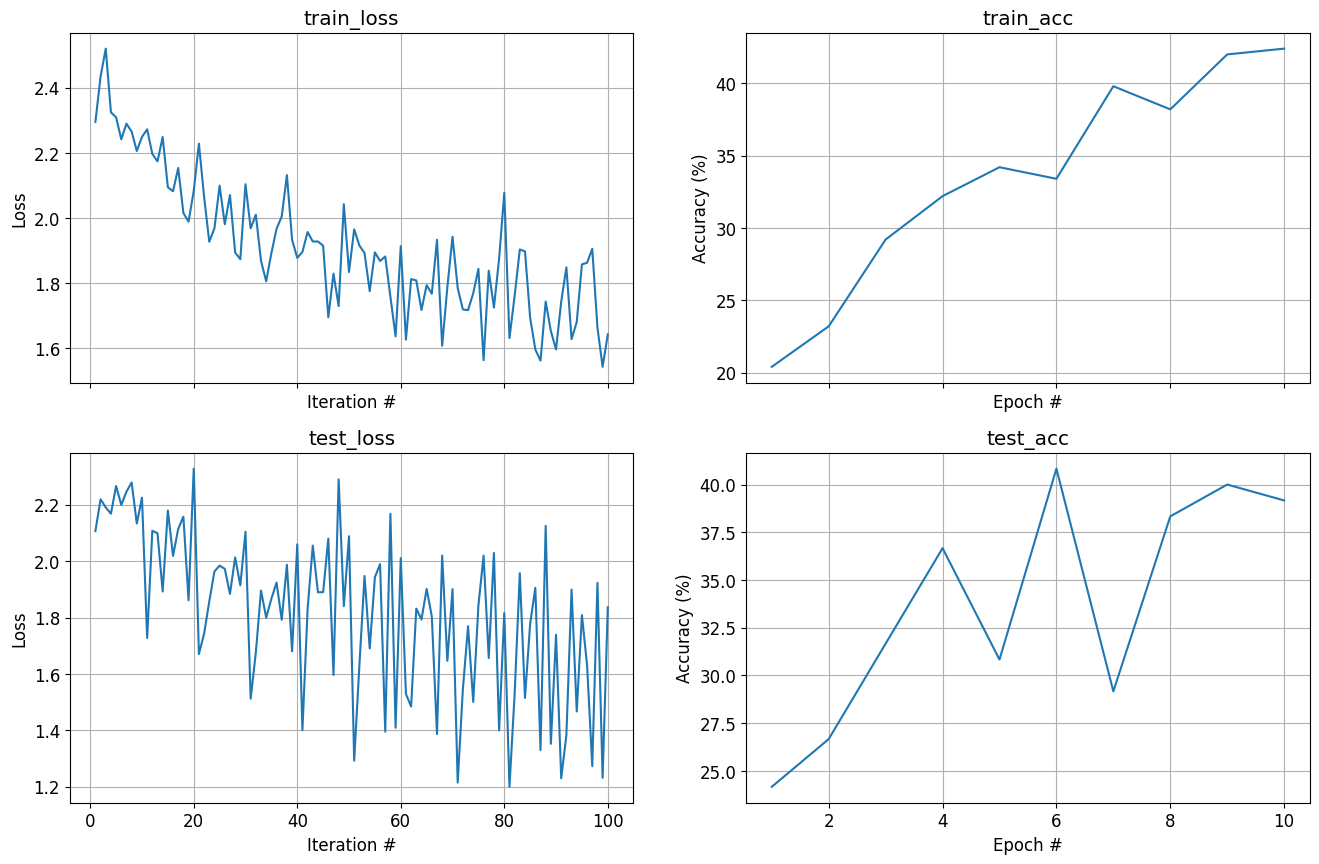

In [12]:
import hw2.experiments as experiments
from hw2.experiments import load_experiment
from cs3600.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
experiments.run_experiment(
    'test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
    filters_per_layer=[32,64], layers_per_block=1, pool_every=1, hidden_dims=[100],
    model_type='resnet',
)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run_L1_K32-64.json')
_, _ = plot_fit(fit_res)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

We'll use the following function to load multiple experiment results and plot them together.

In [13]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_L2_K32`.

**TODO**: Run the experiment on the above configuration with the `ConvClassifier` model. Make sure the result file names are as expected. Use the following blocks to display the results.

In [14]:
! chmod 755 run-exp
! ./run-exp

Streaming output truncated to the last 5000 lines.
--- EPOCH 73/100 ---
train_batch (Avg. Loss 2.303, Accuracy 8.8): 100% 10/10 [00:00<00:00, 60.87it/s]
test_batch (Avg. Loss 2.303, Accuracy 9.2): 100% 10/10 [00:00<00:00, 263.35it/s]
--- EPOCH 74/100 ---
train_batch (Avg. Loss 2.303, Accuracy 9.8): 100% 10/10 [00:00<00:00, 60.98it/s]
test_batch (Avg. Loss 2.304, Accuracy 11.7): 100% 10/10 [00:00<00:00, 298.60it/s]
--- EPOCH 75/100 ---
train_batch (Avg. Loss 2.304, Accuracy 9.4): 100% 10/10 [00:00<00:00, 57.88it/s]
test_batch (Avg. Loss 2.304, Accuracy 11.7): 100% 10/10 [00:00<00:00, 296.29it/s]
--- EPOCH 76/100 ---
train_batch (Avg. Loss 2.304, Accuracy 7.2): 100% 10/10 [00:00<00:00, 60.56it/s]
test_batch (Avg. Loss 2.303, Accuracy 9.2): 100% 10/10 [00:00<00:00, 267.65it/s]
--- EPOCH 77/100 ---
train_batch (Avg. Loss 2.303, Accuracy 11.0): 100% 10/10 [00:00<00:00, 60.67it/s]
test_batch (Avg. Loss 2.303, Accuracy 10.8): 100% 10/10 [00:00<00:00, 286.12it/s]
--- EPOCH 78/100 ---
train_bat

common config:  {'run_name': 'exp1_1', 'out_dir': './results', 'seed': 1862659683, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 100, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


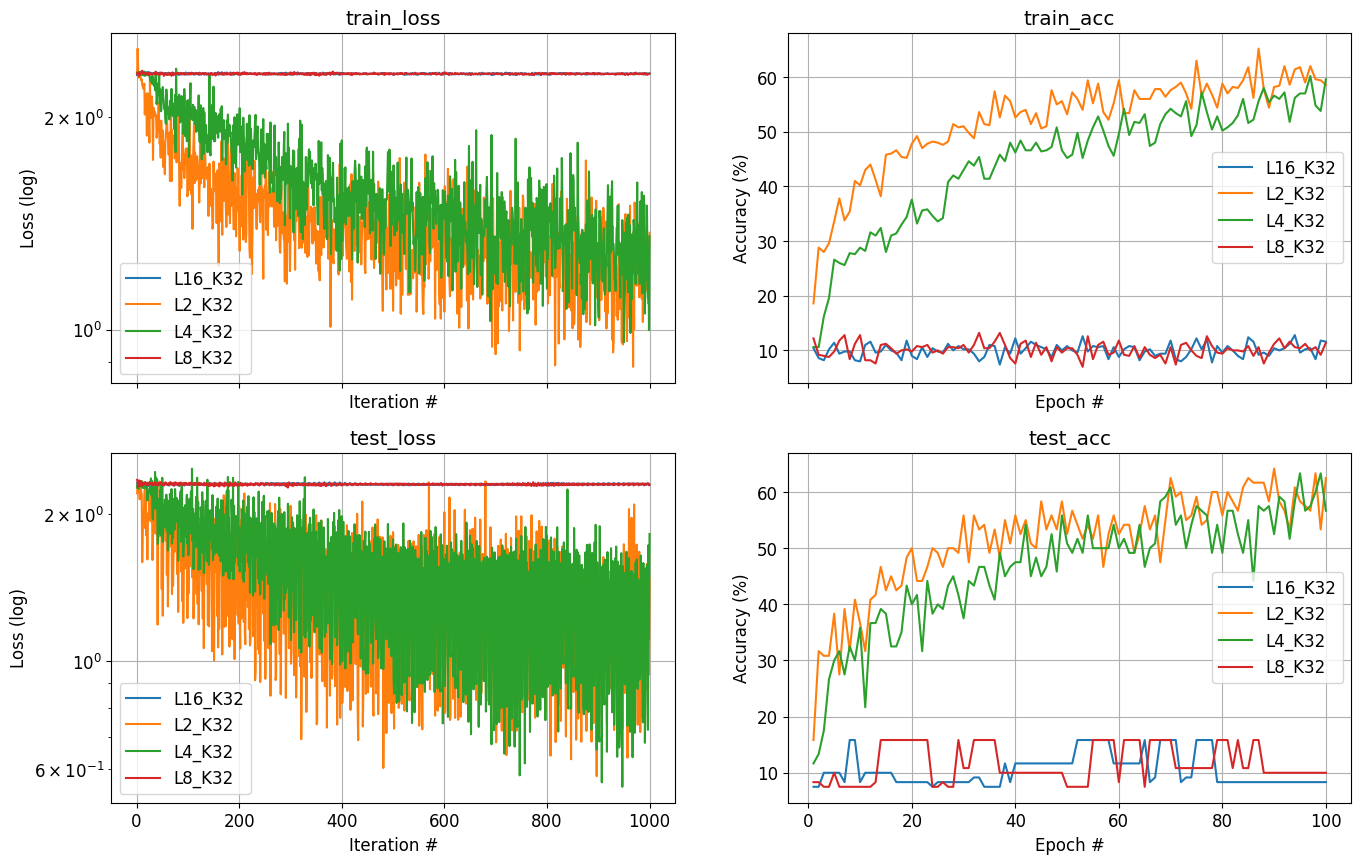

In [15]:
plot_exp_results('exp1_1_L*_K32*.json')

common config:  {'run_name': 'exp1_1', 'out_dir': './results', 'seed': 1740597472, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 100, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


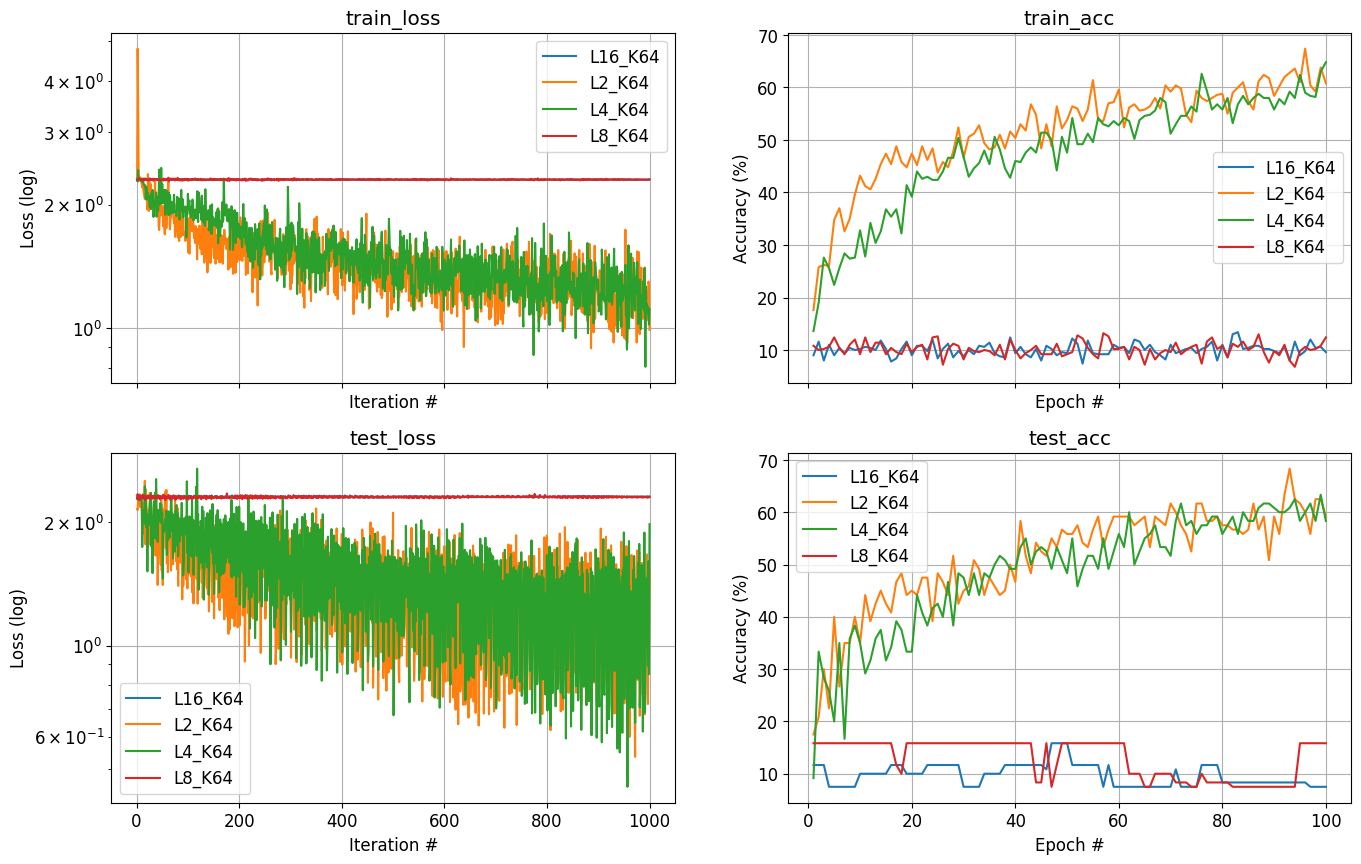

In [16]:
plot_exp_results('exp1_1_L*_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128],[256]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128],[256]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128],[256]` varying per run.

So 12 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`.

**TODO**: Run the experiment on the above configuration with the `ConvClassifier` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 1495717491, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 100, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


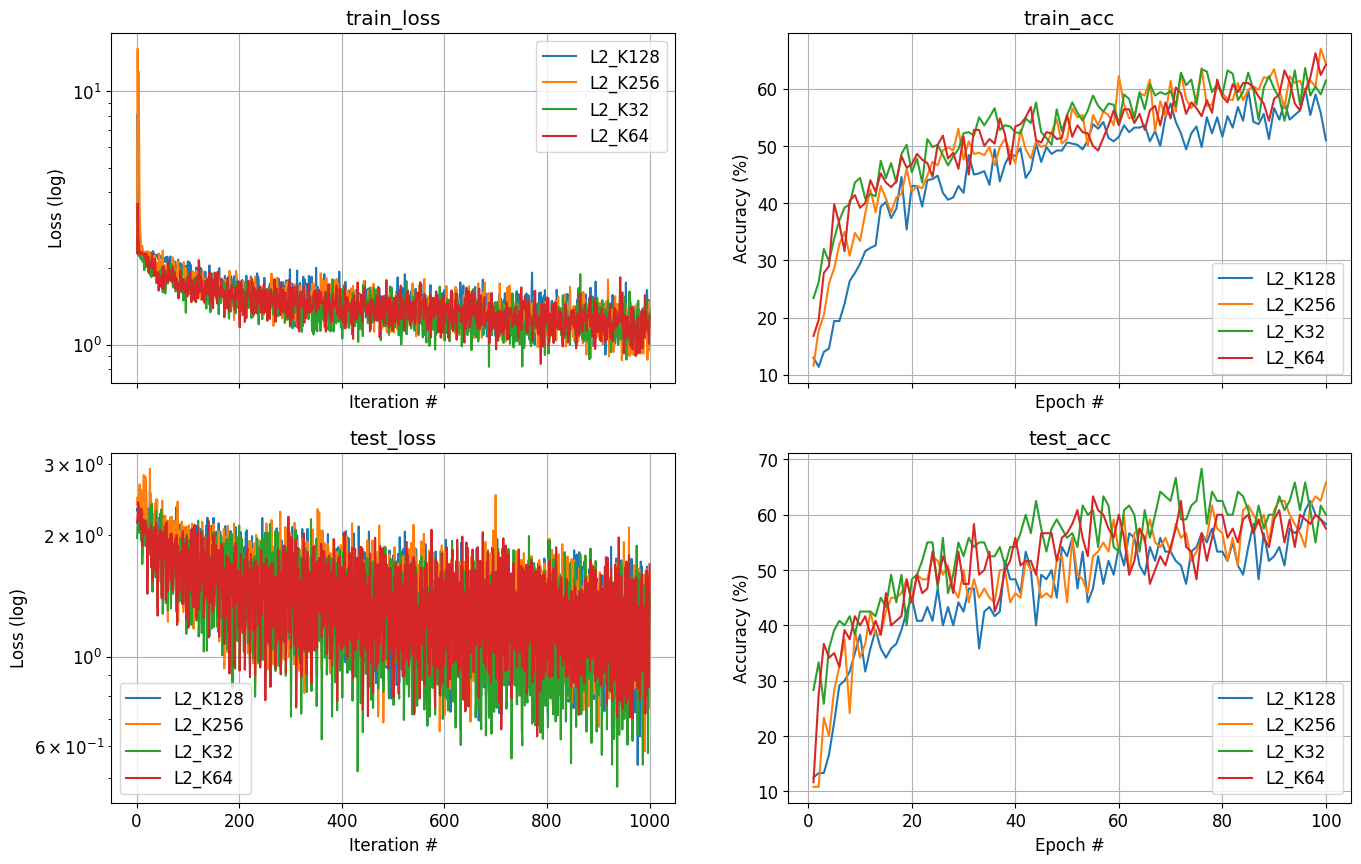

In [17]:
plot_exp_results('exp1_2_L2*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 1431984702, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 100, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


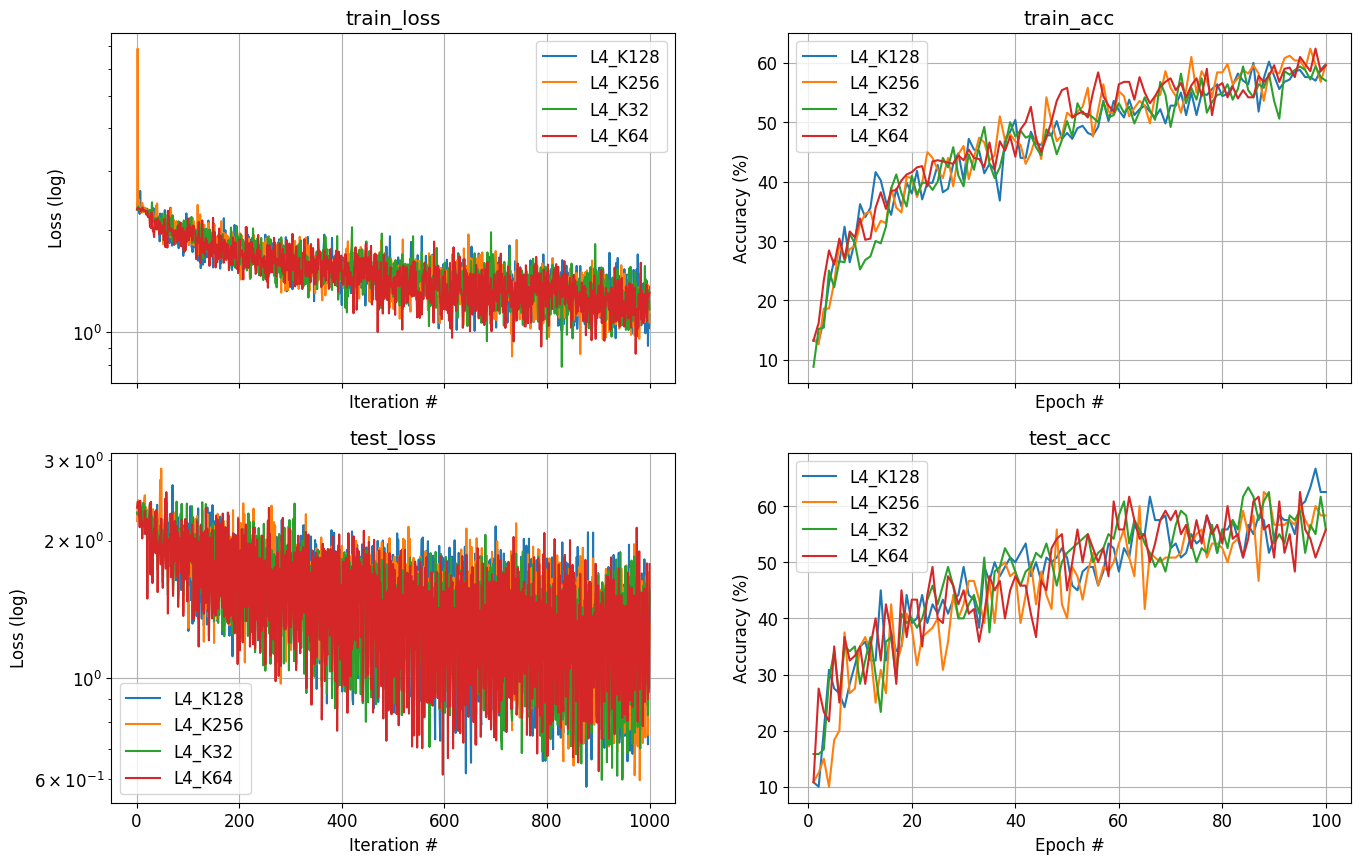

In [18]:
plot_exp_results('exp1_2_L4*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 60780452, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 100, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


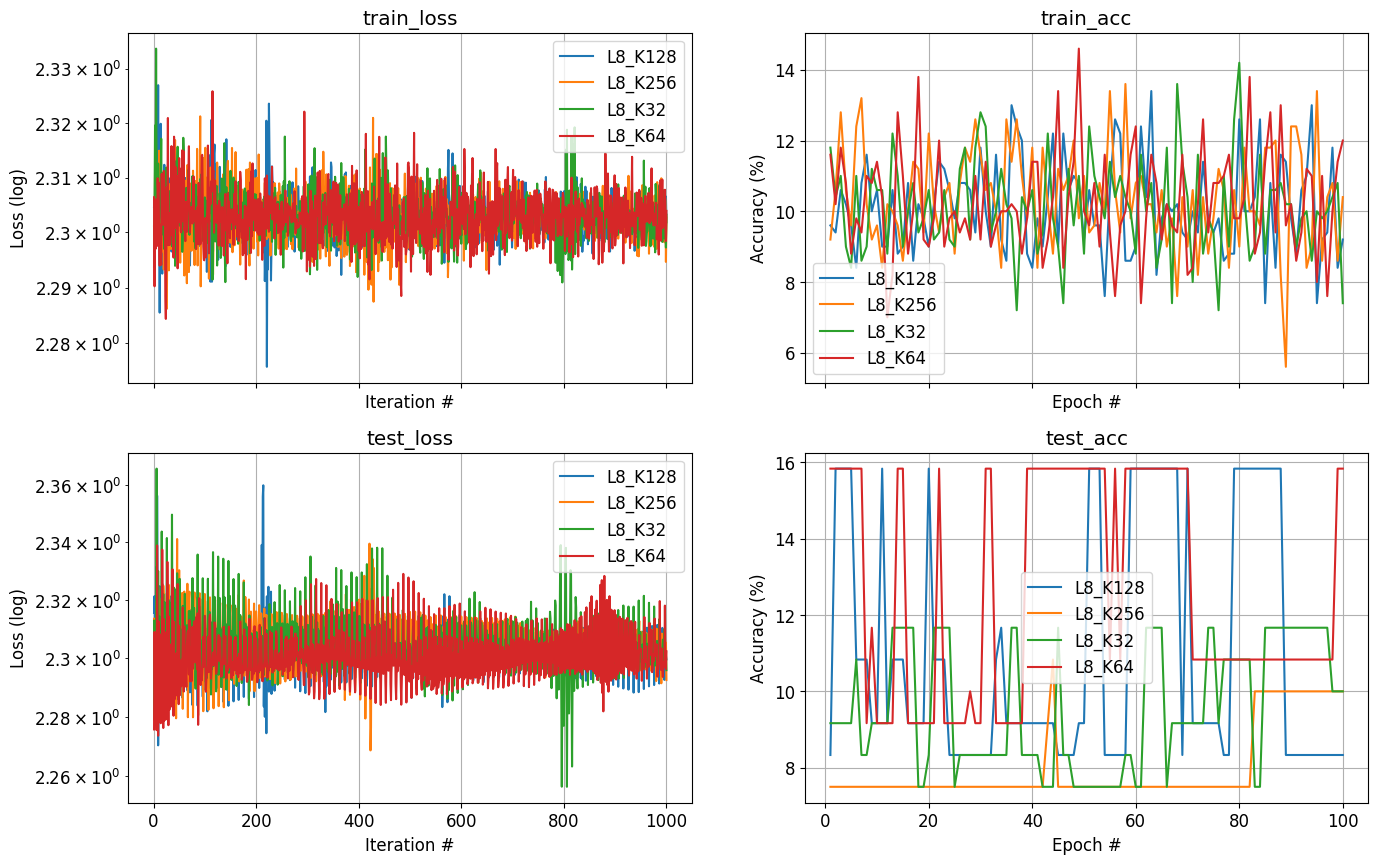

In [19]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128, 256]` fixed with `L=1,2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a three elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L1_K64-128-256`.

**TODO**: Run the experiment on the above configuration  with the `ConvClassifier` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_3', 'out_dir': './results', 'seed': 461479931, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 100, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'cnn', 'kw': {}}


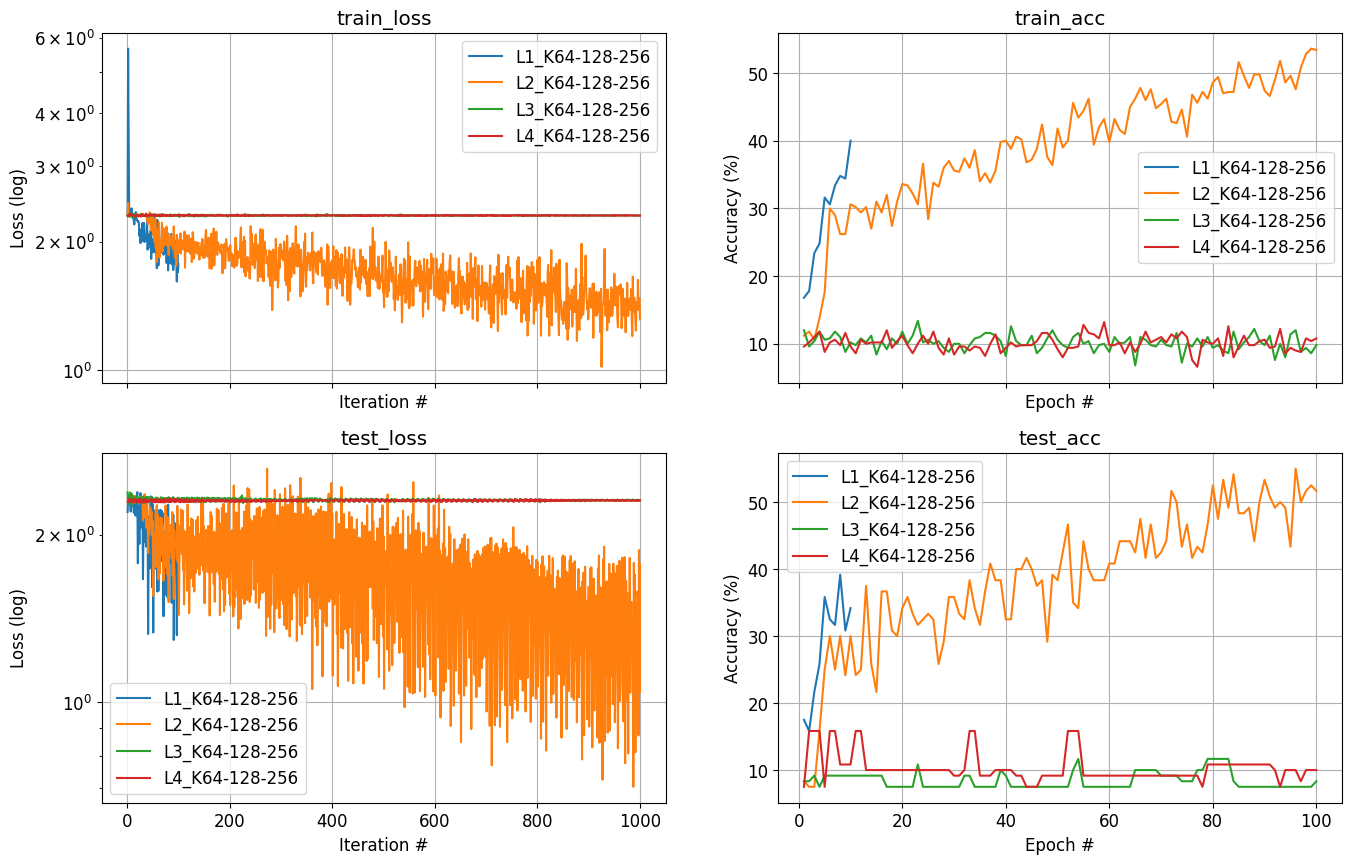

In [20]:
plot_exp_results('exp1_3*.json')

#### Experiment 1.4: Adding depth with Residual Networks

Now we'll test the effect of skip connections on the training and performance.

**Configuratons**:
- `K=[32]` fixed with `L=8,16,32` varying per run.
- `K=[64, 128, 256]` fixed with `L=2,4,8` varying per run.

So 6 different runs in total.

**Naming runs**:
Each run should be named `exp1_4_L{}_K{}-{}-{}` where the braces are placeholders for the values.

**TODO**: Run the experiment on the above configuration with the `ResNetClassifier` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_4', 'out_dir': './results', 'seed': 579187297, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 100, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 8, 'hidden_dims': [100], 'model_type': 'resnet', 'kw': {}}


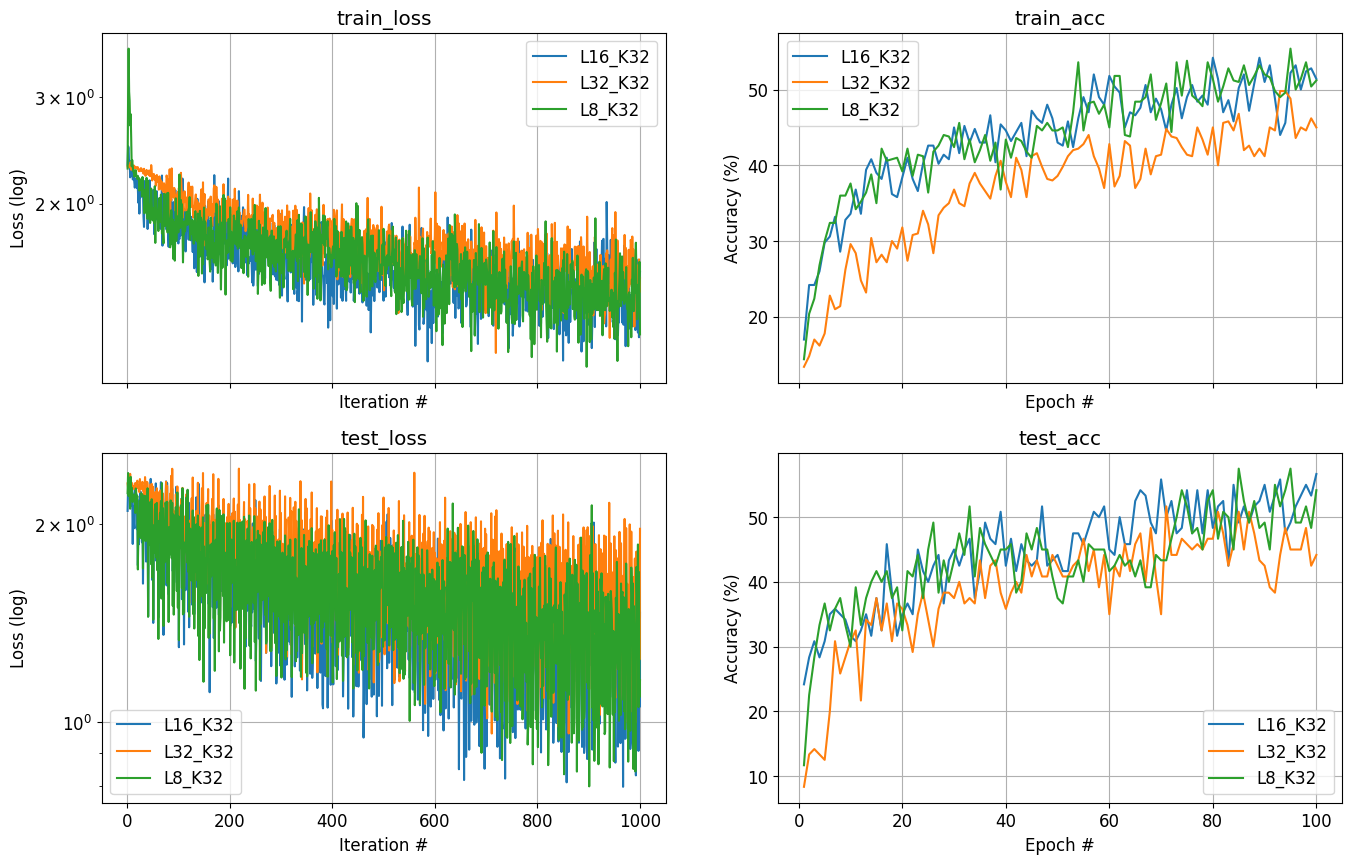

In [21]:
plot_exp_results('exp1_4_L*_K32.json')

common config:  {'run_name': 'exp1_4', 'out_dir': './results', 'seed': 904680805, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 100, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 4, 'hidden_dims': [100], 'model_type': 'resnet', 'kw': {}}


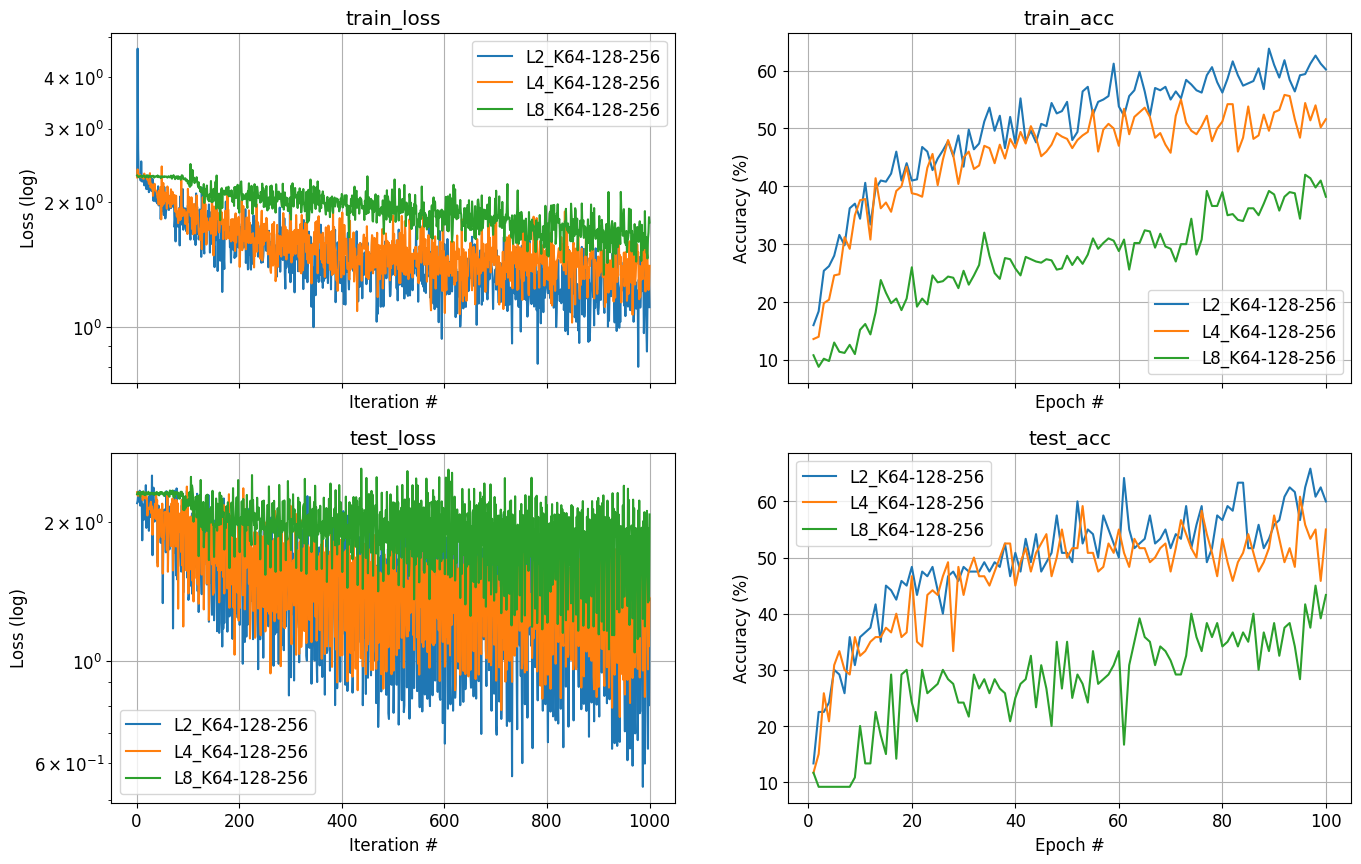

In [22]:
plot_exp_results('exp1_4_L*_K64*.json')

### Experiment 2: Custom network architecture

In this part you will create your own custom network architecture based on the `ConvClassifier` you've implemented.

Try to overcome some of the limitations your experiment 1 results, using what you learned in the course.

You are free to add whatever you like to the model, for instance
- Batch normalization
- Dropout layers
- Skip connections, bottlenecks
- Change kernel spatial sizes and strides
- Custom blocks or ideas from known architectures (e.g. inception module)

Just make sure to keep the model's `init` API identical (or maybe just add parameters).

**TODO**: Implement your custom architecture in the `YourCodeNet` class within the `hw2/cnn.py` module.

In [23]:
net = cnn.YourCodeNet((3,100,100), 10, channels=[32]*4, pool_every=2, hidden_dims=[100]*2)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test_out = net(test_image)
print('out =', test_out)

YourCodeNet(
  (feature_extractor): Sequential(
    (0): SkipConnection(
      (main_path): InceptionBlock(
        (module): ModuleList(
          (0): Sequential(
            (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): Sequential(
            (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (2): Sequential(
            (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (3): Sequential(
            (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): BatchNorm2d(8, eps=1e-05, mom

#### Experiment 2 Configuration

Run your custom model on at least the following:

**Configuratons**:
- `K=[32, 64, 128]` fixed with `L=3,6,9,12` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a three elements.

If you want, you can add some extra runs following the same pattern.
Try to see how deep a model you can train.

**Naming runs**:
Each run should be named `exp2_L{}_K{}-{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp2_L3_K32-64-128`.

**TODO**: Run the experiment on the above configuration with the `YourCodeNet` model. Make sure the result file names are as expected. Use the following blocks to display the results.

In [24]:
! chmod 755 run-exp-2.sh
! ./run-exp-2.sh

*** Starting run_experiment with config:
Namespace(run_name='exp2', out_dir='./results', seed=None, device=None, bs_train=50, bs_test=None, batches=10, epochs=100, early_stopping=5, checkpoints=None, lr=0.001, reg=0.001, filters_per_layer=[32, 64, 128], layers_per_block=3, pool_every=12, hidden_dims=[100], model_type='ycn')
Files already downloaded and verified
Files already downloaded and verified
--- EPOCH 1/100 ---
train_batch (Avg. Loss 8.427, Accuracy 16.4): 100% 10/10 [00:00<00:00, 13.89it/s]
test_batch (Avg. Loss 2.377, Accuracy 16.7): 100% 10/10 [00:00<00:00, 81.97it/s]
--- EPOCH 2/100 ---
train_batch (Avg. Loss 2.291, Accuracy 20.2): 100% 10/10 [00:00<00:00, 23.98it/s]
test_batch (Avg. Loss 2.301, Accuracy 14.2): 100% 10/10 [00:00<00:00, 115.07it/s]
--- EPOCH 3/100 ---
train_batch (Avg. Loss 2.267, Accuracy 23.0): 100% 10/10 [00:00<00:00, 24.39it/s]
test_batch (Avg. Loss 2.057, Accuracy 28.3): 100% 10/10 [00:00<00:00, 122.84it/s]
--- EPOCH 4/100 ---
train_batch (Avg. Loss 2.17

common config:  {'run_name': 'exp2', 'out_dir': './results', 'seed': 1098234272, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 100, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 12, 'hidden_dims': [100], 'model_type': 'ycn', 'kw': {}}


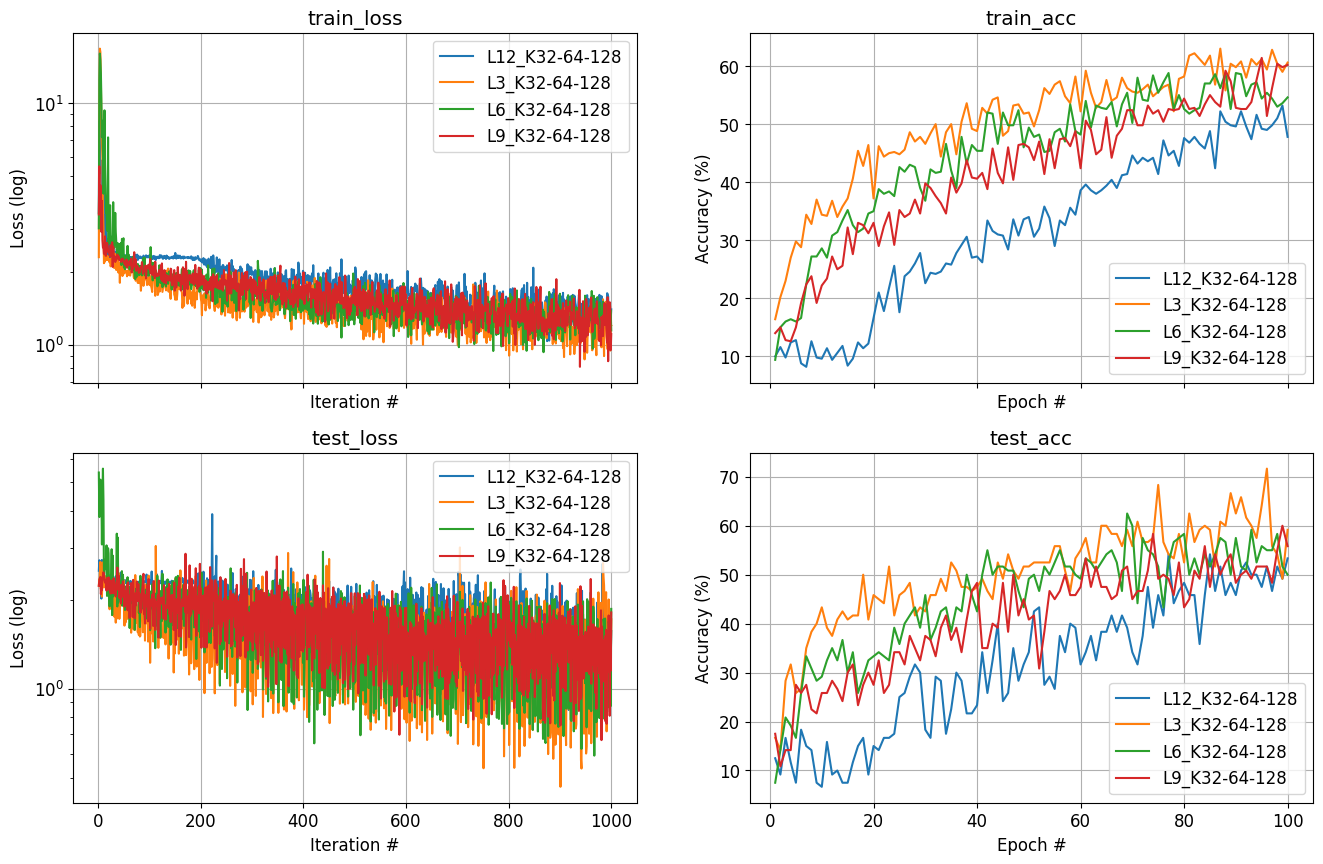

In [25]:
plot_exp_results('exp2*.json')

In [26]:
 !zip -r results.zip results

updating: results/ (stored 0%)
updating: results/exp1_2_L8_K32.json (deflated 69%)
updating: results/exp1_3_L3_K64-128-256.json (deflated 69%)
updating: results/test_run_L1_K32-64.json (deflated 61%)
updating: results/exp1_2_L8_K128.json (deflated 70%)
updating: results/exp1_4_L2_K64-128-256.json (deflated 65%)
updating: results/exp1_2_L4_K128.json (deflated 65%)
updating: results/exp1_4_L4_K64-128-256.json (deflated 65%)
updating: results/exp1_2_L2_K256.json (deflated 65%)
updating: results/exp1_3_L2_K64-128-256.json (deflated 65%)
updating: results/exp1_2_L2_K64.json (deflated 65%)
updating: results/exp1_2_L2_K128.json (deflated 65%)
updating: results/exp1_2_L4_K64.json (deflated 65%)
updating: results/exp1_4_L32_K32.json (deflated 65%)
updating: results/exp1_1_L2_K32.json (deflated 65%)
updating: results/exp1_1_L4_K32.json (deflated 65%)
updating: results/exp2_L6_K32-64-128.json (deflated 65%)
updating: results/exp1_1_L16_K32.json (deflated 69%)
updating: results/exp1_2_L8_K256.json

## Questions
<a id=part3_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [8]:
from cs3600.answers import display_answer
import hw2.answers

### Question 1

Consider the bottleneck block from the right side of the ResNet diagram above.
Compare it to a regular block that performs a two 3x3 convs directly on the 256-channel input (i.e. as shown in the left side of the diagram, with a different number of channels).
Explain the differences between the regular block and the bottleneck block in terms of:

1. Number of parameters. Calculate the exact numbers for these two examples.
2. Number of floating point operations required to compute an output (qualitative assessment).
3. Ability to combine the input: (1) spatially (within feature maps); (2) across feature maps.


In [9]:
display_answer(hw2.answers.part3_q1)


A regular block performing two convolutions with $3\times3$ kernels on an input channel of 256 has $2 \cdot ((3^{2}\cdot 256 +1)\cdot 256)  = 1,180,160$ parameters, while the bottleneck block has $(1^{2}\cdot 256+1)\cdot 64+(3^{2}\cdot 64+1)\cdot 64+(1^{2}\cdot 64+1)\cdot 256  = 70,016$ parameters because the bottleneck block introduces additional methods to reduce the parameter count. It involves a $1\times1$ convolution for channel dimension projection, following which the compact representation (a smaller feature map) is operated on by a $3\times3$ convolution (like the regular block) to extract spatial information, and it concludes with another $1\times1$ convolution to restore the original 256 channels. We can observe that that there is a significant reduction in the parameter count.

The bottleneck block also requires fewer operations for floating point operations compared to the regular block as it processes the input through fewer convolutions, which reduces the computational cost. Assuming an input size of $(256, H, W)$, we consider the number of floating-point operations involved. The regular block requires $(1,180,160 + 256) \times H \times W$ operations, while the bottleneck block requires $(70,016 + 256) \times H \times W$ operations.

The bottleneck block also affects both the spatial dimensions and the number of feature maps of the input, while the regular block only impacts the input spatially. By projecting the channels to a lower dimension and then back to the original dimension, the bottleneck block allows the network to capture spatial and cross-feature map information more effectively, despite having fewer parameters. This can reduce computational complexity and maintain the network's representation ability. Overall, the bottleneck block demonstrates a substantial reduction in parameters and complexity compared to the regular block.


### Question 2

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [10]:
display_answer(hw2.answers.part3_q2)


In general, increasing the depth of a network can lead to improved accuracy, up to a certain point. The caveat is that as the depth increases, the accuracy may stop improving or even decrease. In shallow networks, it may be difficult to capture complex patterns and relationships in the data, so adding more layers lets the network learn more representations, with each layer detecting different features. As the depth increases, the network may struggle with diminishing gradients during back propagation, which may limit the ability of the network's performance. As the depth increases, the network may also learn training examples and over-fit. 

In our experiment, we saw that we achieved the best results are with $L = 2$ and $L = 4$, and that at $L=8$ and $L=16$ we see what essentially can be defined as a flatline (which was confirmed by evaluating the JSON file generated by our experiment). We did not see a significant difference at various values of $K$. At $L =8$ and $L=16$ the reduced performance could be attributed to gradient related issues, where the small gradients fail to backpropagate. For these two values of $L$, the network failed to optimize the loss.

In our experiment, at $L=8$ and $L=16$, the network was untrainable as it was unable to update its weights and optimize the loss function. A potential reason for this is that during backpropagation as gradients were calculated and used to update the weights of the network they got smaller exponentially, resulting in the network failing to update the layers, impacting performance. A potential solution to this is the ResNet architecture we implemented. It introduces residual connections which let the gradient bypass layers and directly propagate between shallow and deep layers. We have already used ReLU to allow the gradient to propagate better between layers, but another solution is to attempt to pretrain the layers and improve performance that way or implement batch normalization, which was added in the ResNet as well. 


### Question 3

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [11]:
display_answer(hw2.answers.part3_q3)


The number of filters per layer can have a significant impact on the performance of a neural network. Increasing the number of filters per layer generally allows the network to capture more complex and fine-grained features in the data. However, we did not see an improvement between the first and second experiment in terms of accuracy, and it was especially evident that at $L=8$ that the model was unable to learn the relationships and had reached a saturation point and the $K$ had little impact. We observed in this experiment that as the network depth increased with a fixed $L$, the model was increasingly difficult to train overall. The exception is in $L=8$ where we had similar results as in previous experiments, regardless of the number of filters at this $L$ we had a model that was entirely unable to train and converged at $13\%$ and $7.5\%$ accuracy for the test and train, no matter the size of the filters. This could potentially be mitigated by selecting an even smaller number of filters but we did not test this hypothesis. In addition to the gradients which we discussed in previous answers, another factor that may contribute to results is the impact of the number of filters can make it harder for the model to learn and generalize effectively as $K$ increases. Despite this, we observed that the model achieved the same train accuracy for all kernel sizes, while in the test accuracy we saw that a higher filter number $(256)$ generally trended toward being the lowest. Another observation is that as the number of filters increases, it takes longer for the model to reach its top accuracy. This could be due to the increased complexity delaying the convergence. An addtional observation of interest was that we saw that as $L$ increased in this experiment, the highest accuracy was achieved with a diminishing $K$. This could be because as the network deepens, the network is able to capture more complex features so using fewer filters per layer may help prevent overfitting, in addition, decreasing the number of filters can also reduce complexity. This may also reduce the propagation path of the gradients when properly tuned.



### Question 4

Analyze your results from experiment 1.3.

In [12]:
display_answer(hw2.answers.part3_q4)


For the configurations with $K=[64, 128, 256]$ and varying $L$ we saw that at $L=4$ the model fails to train effectively as indicated by the flatlining of both training and testing accuracy. The loss also indicates that the model struggles to optimize and improve its performance. Similar to $L=4$, at $L=3$, the model fails to train effectively, with both training and testing accuracy plateauing at the same low values as $L=4$. At $L=2$ we can see that the model is actually learning (an improvement), and has a much better result in training and testing accuracy compared to $L=3$ and $L=4$. However, the accuracy values are still relatively low. The training loss decreases gradually, indicating some learning progress. For $L=1$ The model accuracy appears to disappear after a few epochs while the loss calculations continue (this was confirmed with the JSON). This abrupt disappearance could be due to issues with model stability, overfitting, or suboptimal learning rate, as discussed earlier. 


### Question 5

Analyze your results from experiment 1.4. Compare to experiment 1.1 and 1.3.

In [13]:
display_answer(hw2.answers.part3_q5)


Experiment 1.4, which involves the ResNet architecture with skip connections, differs from the previous experiments (1.1, 1.2, and 1.3) in terms of its architectural design. The previous experiments used a standard convolutional neural network (CNN) without skip connections, while experiment 1.4 introduced the ResNet architecture to address the vanishing gradient problem and enable the training of deeper networks. By incorporating skip connections, the ResNet architecture addresses the vanishing gradient problem and enables the training of deeper networks. In particular, we can observe here that while our accuracy is still not great on test, we can see that for larger values of $L$ the model is able to learn, although it takes longer to reach a high accuracy on train, and that the loss also takes longer to diminish. While the previous experiments may have not achieved high accuracy due to limited epochs and batch sizes, we anticipate that by training the models in experiment 4 with larger batch sizes and more epochs, we may see improved generalization compared to the previous CNN architecture. Additionally, the skip connections may help prevent overfitting and contribute to better overall performance. In this experiment we can see that at $L=8$ we achieve accuracy similar to $L=2$ in other experiments, and this holds for higher values of $L$ as well.


### Question 6

1. Explain your modifications to the architecture which you implemented in the `YourCodeNet` class.
2. Analyze the results of experiment 2. Compare to experiment 1.

In [14]:
display_answer(hw2.answers.part3_q6)


We modified YourCodeNet by introducing dropout rate, kernel size for pooling, and max pool stride variables which can be updated to improve the network. Our class inherits from `ConvClassifier` and overrides `_make_feature_extractor` in addition to implementing a forward method. The architecture is built by iterating over the channel list and creating skip connections with a main path of Inception blocks. We also use a shortcut path (a 1x1 convolution and batch normalization).

The `SkipConnection` module is responsible for creating skip connections within the network, they allow the network to bypass layers and pass information between layers and helps with the vanishing gradient problem. The `InceptionBlock` module implements the Inception block and allows the network to capture features at different scales. Inside the `InceptionBlock` class, a sequence of convolutional layers is created where every layer has an optional dropout and batch normalization which could be used to further improve the model. There is also an activation function. The outputs from all convolutional layers constitute the output of the Inception block.

With these modifications we can see that for larger $L$ our network is learning more effectively than in experiment 1, and that the accuracy differs by roughly $10\%$ from the smallest $L$, $L=3$, and the largest, $L=12$ with the same configuration of $K=[32,64,128]$. The test and train accuracy are also very close with this implementation. 
